# Analysing a 1D double well using TRAM

Import deeptime and other preliminaries...

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from deeptime.clustering import KMeans
from deeptime.markov.msm import TRAM, TRAMDataset

## The system
We define the potential to be a simple double well.

In [2]:
def potential(x):
    return 10 * (x - 1) ** 4 * (x + 1) ** 4

Plot the potential over the range of interest

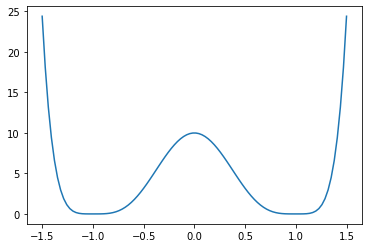

In [3]:
x_min = -1.5
x_max = 1.5

xs = np.linspace(x_min, x_max, num=100) # We will sample 100 discrete bins
plt.plot(xs, potential(xs));

## Sampling

The following is a simple markov-chain Monte Carlo (MCMC) sampling algorithm that samples our potential `U`.

In [4]:
# this is a simple markov-chain monte carlo (MCMC) sampler that samples a trajectory
# in an n-dimensional space given a potential function U.
def sample_MCMC(U, d, beta=1.0, n_steps=1000, max_stepsize=1.):
    trajectory = np.zeros((n_steps, d), dtype=np.float32)
    p = lambda u: np.exp(-beta * u)
    r_prev = np.random.uniform(0, 8, size=d)

    for n in range(n_steps):

        r = r_prev + 2 * max_stepsize * (np.random.uniform(size=d)) - max_stepsize

        delta = U(r) - U(r_prev)
        if delta > 0:
            if p(delta) < np.random.uniform():
                r = r_prev
            else:
                r_prev = r
        else:
            r_prev = r

        trajectory[n] = r
    return trajectory

### An example trajectory
We sample an example trajectory. As we will very likely see in the histogram, we get stuck in one of the wells, and don't cross the barrier.

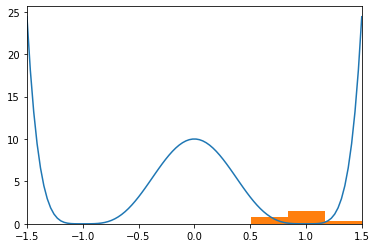

In [22]:
traj = sample_MCMC(potential, 1, n_steps=100)

plt.hist(traj, bins=10, density=True, color='C1');
plt.plot(xs, potential(xs))
plt.xlim(x_min, x_max);

### Sampling at multiple temperatures
To solve this sampling problem we will sample at multiple temperatures. We define six thermodynamic states by their temperatures. The unnormalized probabilities for each temperature are plotted. As we kan see, the higher the temperature, the more flattened the shape of the probability distribution becomes.

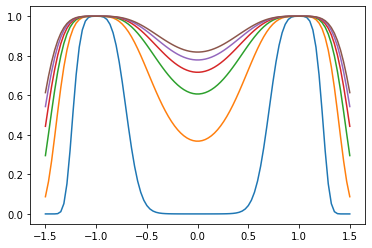

In [23]:
temperatures = [1, 10, 20, 30, 40, 50]  # six temperatures to perform parallel tempering.

for T in temperatures:
    plt.plot(xs, np.exp(-(1/T)* potential(xs)))

Now we will sample a trajectory for each of the the temperatures.

In [24]:
N_SAMPLES_PER_TRAJ = 10000
trajectories = []

for T in temperatures:
    print(f"sampling for T={T} ...")
    traj = sample_MCMC(potential, 1, beta=1/T, n_steps=N_SAMPLES_PER_TRAJ, max_stepsize=2.)
    trajectories.append(traj.squeeze())
print('done!')

sampling for T=1 ...
sampling for T=10 ...
sampling for T=20 ...
sampling for T=30 ...
sampling for T=40 ...
sampling for T=50 ...
done!


We can plot a histogram of all trajectories to see the distribution we samples. By sampling at multiple temperatures, we were now able to sample in the transition region.

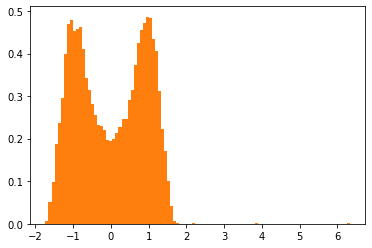

In [25]:
plt.hist(np.concatenate(trajectories), bins=100, density=True, color='C1',
         label='Histogram over visited states');

## Analysing the data with TRAM
Now we want recombine our data to obtain the original potential function. We do this by analysing our data using TRAM. 

### Bias matrices
First, we construct the bias energy matrices by computing the bias potential for each sample in each state. The bias energy for a temperature biased simulation is given by $b^k(x) = (\beta^k - \beta^0) U^0(x)$. In this example, we assume all quantities are unitless.

When we print the shape of one of the bias matrices we see it has shape `(N, S)`, `N` being the number of samples, and `S` the number of thermodynamic states. Thus, for each sample we have computed the energy of that sample in _all_ states.

In [26]:
bias_matrices = []

betas = np.asarray(temperatures, dtype=float)**-1
bias_factors = betas - betas[0]

for traj in trajectories:
    energies = potential(traj)
    bias_potentials = energies[:, None] * bias_factors
    bias_matrices.append(bias_potentials)
    
print(bias_matrices[0].shape)

(10000, 6)


### The discrete trajectories
Now we discretize our samples into 10 Markov states along the x-axis. The discretized trajectories (`dtrajs`) are what allow `TRAM` to compute state counts and transition counts.

In [29]:
n_bins = 10
markov_states = np.linspace(x_min, x_max, n_bins, endpoint=False)

dtrajs = [np.digitize(traj, markov_states, right=False) for traj in trajectories]

### Applying TRAM
Now, we are ready to analyse the data using TRAM. We set connectivity='summed_count_matrix' because we assume all states are connected since they are distributed along a one-dimensional axis. In a realistic scenario, you should reduce your data to the largest connected set after clustering.

In [30]:
# first construct the dataset...
dataset = TRAMDataset(dtrajs=dtrajs, bias_matrices=bias_matrices)
dataset.restrict_to_largest_connected_set(connectivity='summed_count_matrix', progress=tqdm)

# ... and use that run TRAM 
tram = TRAM(lagtime=10, maxiter=1000, progress=tqdm, callback_interval=3)
model = tram.fit_fetch((dtrajs, bias_matrices))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## Estimating the PMF
Now we want to recover the potential of mean force (PMF). To do this, we define a number of bins (in this case 25) that we want to calculate the unbiased PMF over. We essentially calculate a probability distribution over all bins, and then take the negative logarithm to recover the PMF. 

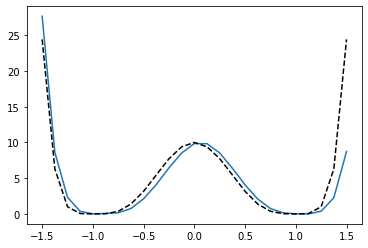

In [31]:
n_bins = 25
bins = np.linspace(-1.5, 1.5, n_bins)

# the bin number for each sample. Samples are binned into 25 bins
bin_numbers = [np.digitize(traj, bins, right=True) for traj in trajectories]

# pass samples to the model with their corresponding bin numbers
pmf = model.compute_PMF(dtrajs, bias_matrices, bin_numbers, n_bins = n_bins)
plt.plot(bins, pmf - pmf.min())

# compare with the original distribution, shifted so that the minimum lies at zero.
plt.plot(bins, potential(bins) - potential(bins).min(), 'k--');